C:\Users\yoswald\AppData\Local\Temp\ipykernel_29664\2896403968.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Filter frequency 2 repetitions:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Filter frequency 2 repetitions:   5%|▌         | 1/20 [00:02<00:50,  2.67s/it]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountere

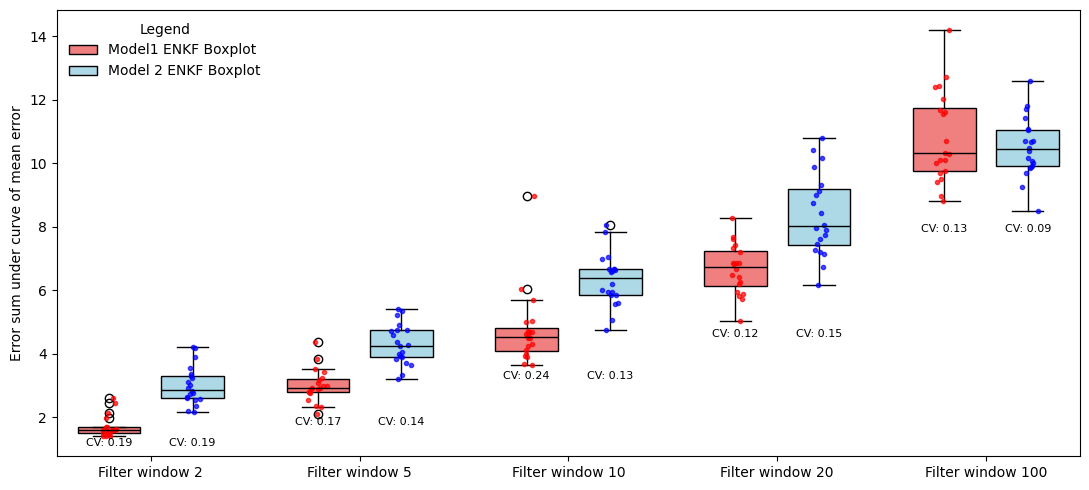

In [1]:

#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *


#%%
''' this experiment investigate the influence 
of the filter frequency on the ENKF performance '''

##### for this experiment change the test period to a much shorter one
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'prepare_enkf', 'prepare_enkf2', 'run_enkf', and 'run_enkf2' are defined elsewhere

class Enkf_experiment2:
    
    def __init__(self, num_agents, macro_state_dim, repetitions, filter_frequencies):
        self.num_agents = num_agents
        self.macro_state_dim = macro_state_dim
        self.repetitions = repetitions
        self.filter_frequencies = filter_frequencies ### if = 10 then every 10th time steps etc.
        self.results = []
        
    def run_experiment(self, time_horizon):
        
        model_params1 = {"population_size": 100,
         "growth_rate": 0.025,
         "b_begin": 1.3,
         "distribution": "Pareto_lognormal",
         "start_year": 1990,
         "uncertainty_para": 0}
        
        model_params2 = {"population_size": 100, 
                        "concavity": 1,
                        "growth_rate": 0.025, 
                        "start_year": 1990,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        for freq in self.filter_frequencies:
            array_of_results_enkf1 = np.zeros((self.repetitions, 1))
            array_of_results_enkf2 = np.zeros((self.repetitions, 1))
            for i in tqdm(range(self.repetitions), desc=f"Filter frequency {freq} repetitions"):
                enkf1 = prepare_enkf(Model1,
                                          model_params= model_params1,
                                          ensemble_size = 10,
                                          macro_state_dim = self.macro_state_dim,
                                          filter_freq = freq,
                                          uncertainty_obs = 0.05)
                enkf2 = prepare_enkf(Model2, model_params= model_params2,
                                          ensemble_size = 10,
                                          macro_state_dim = self.macro_state_dim,
                                          filter_freq = freq,
                                          uncertainty_obs = 0.05)
                run_enkf(enkf1, time_horizon, freq)
                run_enkf(enkf2, time_horizon, freq)
                array_of_results_enkf1[i, 0] = enkf1.integral_error()
                array_of_results_enkf2[i, 0] = enkf2.integral_error()
                
            self.results.append([f'Filter window {freq}', array_of_results_enkf1, array_of_results_enkf2])
    
    def plot_results(self, save_fig=False, fig_name='fig5.png'):

        fig, ax = plt.subplots()
        boxplot_artists = []
        positions = np.arange(len(self.results)) * 2

        for i, (label, array1, array2) in enumerate(self.results):
            pos = positions[i] + np.array([-0.4, 0.4])
            box1 = ax.boxplot(array1, positions=[pos[0]], widths=0.6, patch_artist=True)
            box2 = ax.boxplot(array2, positions=[pos[1]], widths=0.6, patch_artist=True)
            plt.setp(box1["boxes"], facecolor='lightcoral')
            plt.setp(box1["medians"], color='black')
            plt.setp(box2["boxes"], facecolor='lightblue')
            plt.setp(box2["medians"], color='black')

            # Calculate coefficient of variation
            cv1 = np.std(array1) / np.mean(array1)
            cv2 = np.std(array2) / np.mean(array2)

            # Annotate coefficient of variation below the boxplots
            y_offset = min(np.min(array1), np.min(array2)) - (0.05 * np.abs(min(np.min(array1), np.min(array2))))
            ax.text(pos[0], y_offset, f'CV: {cv1:.2f}', ha='center', va='top', fontsize=8)
            ax.text(pos[1], y_offset, f'CV: {cv2:.2f}', ha='center', va='top', fontsize=8)

            ax.plot(np.random.normal(pos[0], 0.04, size=len(array1)), array1, 'r.', alpha=0.7)
            ax.plot(np.random.normal(pos[1], 0.04, size=len(array2)), array2, 'b.', alpha=0.7)
            if i == 0:
                boxplot_artists.append(box1['boxes'][0])
                boxplot_artists.append(box2['boxes'][0])
                
        ax.set_xticks(positions)
        ax.set_xticklabels([label for label, _, _ in self.results])
        ax.set_ylabel('Error sum under curve of mean error')
        legend_labels = ['Model1 ENKF Boxplot', 'Model 2 ENKF Boxplot']
        ax.legend(boxplot_artists, legend_labels, title='Legend', loc="upper left", frameon=False)

        plt.tight_layout()
        if save_fig:
            plt.savefig(fig_name, dpi=300)
        plt.show()
        
    def compute_elasticity_fit(self):
    
        means1 = np.zeros((len(self.results), 1))
        means2 = np.zeros((len(self.results), 1))

        for idx, (label, array1, array2) in enumerate(self.results):
            means1[idx, 0] = np.mean(array1)
            means2[idx, 0] = np.mean(array2)

       # print(means1)
        #print(means2)

        # Transform to log space for linear regression
        log_means1 = np.log(means1)
        log_means2 = np.log(means2)
        log_filter_frequencies = np.log(self.filter_frequencies)

        # Perform the linear regression in log space
        # The slope will be the exponent b and the intercept will be log(a)
        slope1, intercept1 = np.polyfit(log_filter_frequencies, log_means1.ravel(), 1)
        slope2, intercept2 = np.polyfit(log_filter_frequencies, log_means2.ravel(), 1)

        # Convert intercept into the coefficient a in the original space
        a1 = np.exp(intercept1)
        a2 = np.exp(intercept2)
        
        # Return the coefficients (a, b) for both fits
        return (a1, slope1), (a2, slope2)

# To use the class
num_agents = 100
macro_state_dim = 4
repetitions = 20
time_horizon = 3*12
filter_frequencies = [2, 5, 10, 20, 100] # [20,100] #

experiment = Enkf_experiment2(num_agents, macro_state_dim, repetitions, filter_frequencies)
experiment.run_experiment(time_horizon)
experiment.plot_results(save_fig=True)
elasticities = experiment.compute_elasticity_fit()


In [2]:
print(elasticities)

((1.3940828805176613, 0.47494617774650144), (2.657128242843392, 0.3274837304216213))
